In [1]:
print("hello")

hello


Loading Base Model (Qwen/Qwen2.5-7B-Instruct)...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading Probe from transformer_creativity_probe_enhanced.pt...
✅ Probe Loaded Successfully!
   - Input Dim: 3584
   - Target Layer: 24
   - Trained Description: N/A

=== 🧪 Running Verification Benchmark ===
Type       | Logit    | Text Snippet
------------------------------------------------------------
Cliché     |  -2.1703 | A to-do list app that helps you organize...
Novel      |   7.3180 | A social network that only allows postin...
Nonsense   |   7.6002 | A blockchain-based quantum toaster that ...
Cliché     |   4.8817 | A detective solves a murder in a small t...
Novel      |   8.6862 | A murder mystery where the detective is ...
Nonsense   |   4.7079 | The void whispered to the cybernetic dra...
Cliché     |   1.0107 | Using deep learning to classify images o...
Novel      |   8.2337 | Training LLMs using simulated debates be...
Nonsense   |   3.6766 | Fine-tuning a neural network on the tast...


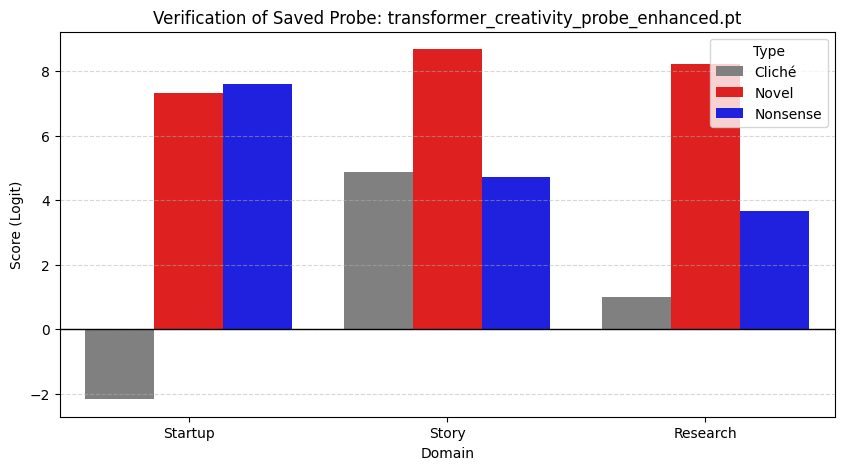


=== 📝 Final Verdict ===
Average Novel Score:  8.08
Average Cliché Score: 1.24
✅ PASS: The probe clearly prefers novel ideas.
   (このモデルは信頼してPPOに使えます)


In [2]:
# =================================================================
# verify_saved_probe.py
# 目的: 保存された .pt ファイルをロードし、その性能を客観的に再評価する
# =================================================================

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# ==========================================
# 1. 設定 & モデル定義 (保存時と同じクラス構造)
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
# PROBE_PATH = "transformer_creativity_probe.pt" # 先ほど保存したパス
PROBE_PATH = "transformer_creativity_probe_enhanced.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class TransformerProbe(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=4):
        super().__init__()
        self.project = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.head = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.project(x)
        x = self.transformer(x)
        x = x.mean(dim=1) 
        return self.head(x)

# ==========================================
# 2. ロード処理
# ==========================================
print(f"Loading Base Model ({MODEL_NAME})...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# 特徴量抽出だけなのでCausalLMでOK
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.float16, 
    device_map="auto"
)
base_model.eval()

print(f"Loading Probe from {PROBE_PATH}...")
try:
    checkpoint = torch.load(PROBE_PATH, map_location=DEVICE)
    config = checkpoint["config"]
    
    probe = TransformerProbe(
        input_dim=config["input_dim"],
        d_model=config["d_model"],
        nhead=config["nhead"]
    ).to(DEVICE)
    
    probe.load_state_dict(checkpoint["model_state_dict"])
    probe.eval()
    
    TARGET_LAYER = config["layer_idx"]
    print(f"✅ Probe Loaded Successfully!")
    print(f"   - Input Dim: {config['input_dim']}")
    print(f"   - Target Layer: {TARGET_LAYER}")
    print(f"   - Trained Description: {checkpoint.get('description', 'N/A')}")
    
except Exception as e:
    print(f"❌ Error loading probe: {e}")
    exit()

# ==========================================
# 3. 評価関数
# ==========================================
def get_creativity_score(text):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = base_model(**inputs, output_hidden_states=True)
        
    # 指定層のHidden Stateを取得 [1, Seq, Dim] -> [Seq, Dim]
    h = outputs.hidden_states[TARGET_LAYER].squeeze(0).float()
    
    # Probeに入力 (バッチ次元追加 [1, Seq, Dim])
    with torch.no_grad():
        logit = probe(h.unsqueeze(0)).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
        
    return logit, prob

# ==========================================
# 4. アイデア評価ベンチマーク (厳選版)
# ==========================================
print("\n=== 🧪 Running Verification Benchmark ===")

benchmarks = [
    # --- Startup Ideas ---
    ("Startup", "Cliché", "A to-do list app that helps you organize tasks."),
    ("Startup", "Novel", "A social network that only allows posting once a year to encourage thoughtful content."),
    ("Startup", "Nonsense", "A blockchain-based quantum toaster that mines crypto while browning bread."),

    # --- Story Plots ---
    ("Story", "Cliché", "A detective solves a murder in a small town."),
    ("Story", "Novel", "A murder mystery where the detective is the ghost of the victim, but has amnesia."),
    ("Story", "Nonsense", "The void whispered to the cybernetic dragon about the synergy of silence."),

    # --- Research Ideas (ここが鬼門) ---
    ("Research", "Cliché", "Using deep learning to classify images of cats and dogs."),
    ("Research", "Novel", "Training LLMs using simulated debates between historical figures to improve reasoning."),
    ("Research", "Nonsense", "Fine-tuning a neural network on the taste of the color blue."),
]

results = []

print(f"{'Type':10s} | {'Logit':8s} | Text Snippet")
print("-" * 60)

for domain, type_, text in benchmarks:
    logit, prob = get_creativity_score(text)
    results.append({
        "Domain": domain,
        "Type": type_,
        "Score (Logit)": logit,
        "Prob": prob
    })
    print(f"{type_:10s} | {logit:8.4f} | {text[:40]}...")

# ==========================================
# 5. 結果の可視化と判定
# ==========================================
df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Domain", y="Score (Logit)", hue="Type", 
            palette={"Cliché": "gray", "Novel": "red", "Nonsense": "blue"})
plt.axhline(0, color="black", linewidth=1.0)
plt.title(f"Verification of Saved Probe: {PROBE_PATH}")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 自動判定
print("\n=== 📝 Final Verdict ===")
avg_novel = df[df["Type"]=="Novel"]["Score (Logit)"].mean()
avg_cliche = df[df["Type"]=="Cliché"]["Score (Logit)"].mean()

print(f"Average Novel Score:  {avg_novel:.2f}")
print(f"Average Cliché Score: {avg_cliche:.2f}")

if avg_novel > avg_cliche + 1.0:
    print("✅ PASS: The probe clearly prefers novel ideas.")
    print("   (このモデルは信頼してPPOに使えます)")
elif avg_novel > avg_cliche:
    print("⚠️ WARN: Distinction is weak but present.")
else:
    print("❌ FAIL: The probe cannot distinguish creativity.")